# Project Goals

- examine various recomendation systems with and without user ratings.



# Imports & Getting the data

In [594]:
from random import gauss as gs, uniform as uni, seed
import numpy as np
import pandas as pd
from datetime import datetime

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

import matplotlib.pyplot as plt

In [595]:
movies = pd.read_csv('Data/movies.csv')
ratings = pd.read_csv('Data/ratings.csv')
tags = pd.read_csv('Data/tags.csv')

## Examining & Cleaning the Data!

The movie and rating CSVs are fairly self-explainatory (providing movies, reviews, and users), so we'll start there.

In [596]:
def get_movie_name(movie_id):
    try:
        return movies.loc[movie_id, 'title']
    except KeyError:
        return "Movie not found"

def get_movie_genres(movie_id):
    try:
        return movies.loc[movie_id, 'genres']
    except KeyError:
        return "Movie not found"

def get_movie_year(movie_id):
    try:
        return movies.loc[movie_id, 'year']
    except KeyError:
        return "Movie not found"

def get_movie_rating(movie_id):
    try:
        rating = movies.loc[movie_id, 'avg_rating']
        return f'{round(rating,2)}'
    except KeyError:
        return "Movie rating not found"

def get_movie_num_reviews(movie_id):
    try:
        num = movies.loc[movie_id, 'num_reviews']
        return f'{int(num)} users'
    except KeyError:
        return " "

def movie_pretty_string(movie_id):
    try:
        string = f'{get_movie_name(movie_id)}, {get_movie_year(movie_id)}   | {get_movie_rating(movie_id)} by {get_movie_num_reviews(movie_id)} users |  {get_movie_genres(movie_id)}'
        return string
    except KeyError:
        return "Movie not found"

### Movies

In [597]:
#Problems: Year is tied into the title, no reviews, genres are a pipe separated list, ids are present, but not the indexes
movies.set_index('movieId', inplace=True)
movies.sample(5)

title                genres
movieId                                             
3991     102 Dalmatians (2000)       Children|Comedy
48516     Departed, The (2006)  Crime|Drama|Thriller
142196        Cornered! (2009)         Comedy|Horror
102033      Pain & Gain (2013)   Action|Comedy|Crime
115216   Salvation, The (2014)         Drama|Western

In [598]:
#Get the year from title
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True).astype(str)
movies['title'] = movies.title.str[:-7]

In [599]:
#Add the mean rating for each movie
ratings_movie_mean = ratings.groupby('movieId').mean()
mean_rating = ratings.groupby('movieId').mean()['rating']
movies['avg_rating'] = mean_rating
movies['num_reviews'] = ratings.groupby('movieId').count()['rating']

In [600]:
fig = px.bar(movies, x='year', y='avg_rating', hover_data=['title', 'num_reviews'])

fig.update_layout(
    title_text='Movies', # title of plot
    xaxis_title_text='Year', # xaxis label
    yaxis_title_text='Number of Movies Released', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
)

fig.show()


In [601]:
df_temp = movies
df_temp['decade'] = df_temp['year'].str[:3]+'0s'
movies['decade'] = df_temp['year'].str[:3]+'0s'
df_temp = df_temp.groupby(['decade'])['title'].count()
df_temp

fig = px.bar(df_temp, text_auto=True)

fig.update_layout(
    title_text='Movies released per decade', # title of plot
    xaxis_title_text='Decade', # xaxis label
    yaxis_title_text='Number of Movies Released', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
)

fig.show()

In [602]:
#make the genres a csv
def unpack_genres(string):
    s = string.split('|')
    return s

movies['genres'] = movies['genres'].map(unpack_genres)

In [603]:
unique_genres = [ ]
for row in movies['genres']:
    for genre in row:
        if genre not in unique_genres:
            unique_genres.append(genre)

unique_genres

['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 'War',
 'Musical',
 'Documentary',
 'IMAX',
 'Western',
 'Film-Noir',
 '(no genres listed)']

### Creating a sparse matrix of Genres

In [604]:
movie_genre_matrix = pd.DataFrame()
movie_genre_matrix['movieId'] = movies.index

for genre in unique_genres:
    movie_genre_matrix[genre] = movies['genres'].apply(lambda x: 1 if genre in x else 0)

for col in movie_genre_matrix.columns:
    summ = movie_genre_matrix[col].sum()
    print(f'{col} has {summ} movies')


movieId has 411115845 movies
Adventure has 627.0 movies
Animation has 172.0 movies
Children has 361.0 movies
Comedy has 2047.0 movies
Fantasy has 336.0 movies
Romance has 995.0 movies
Drama has 2556.0 movies
Action has 873.0 movies
Crime has 656.0 movies
Thriller has 995.0 movies
Horror has 513.0 movies
Mystery has 310.0 movies
Sci-Fi has 472.0 movies
War has 231.0 movies
Musical has 229.0 movies
Documentary has 167.0 movies
IMAX has 19.0 movies
Western has 110.0 movies
Film-Noir has 68.0 movies
(no genres listed) has 0.0 movies


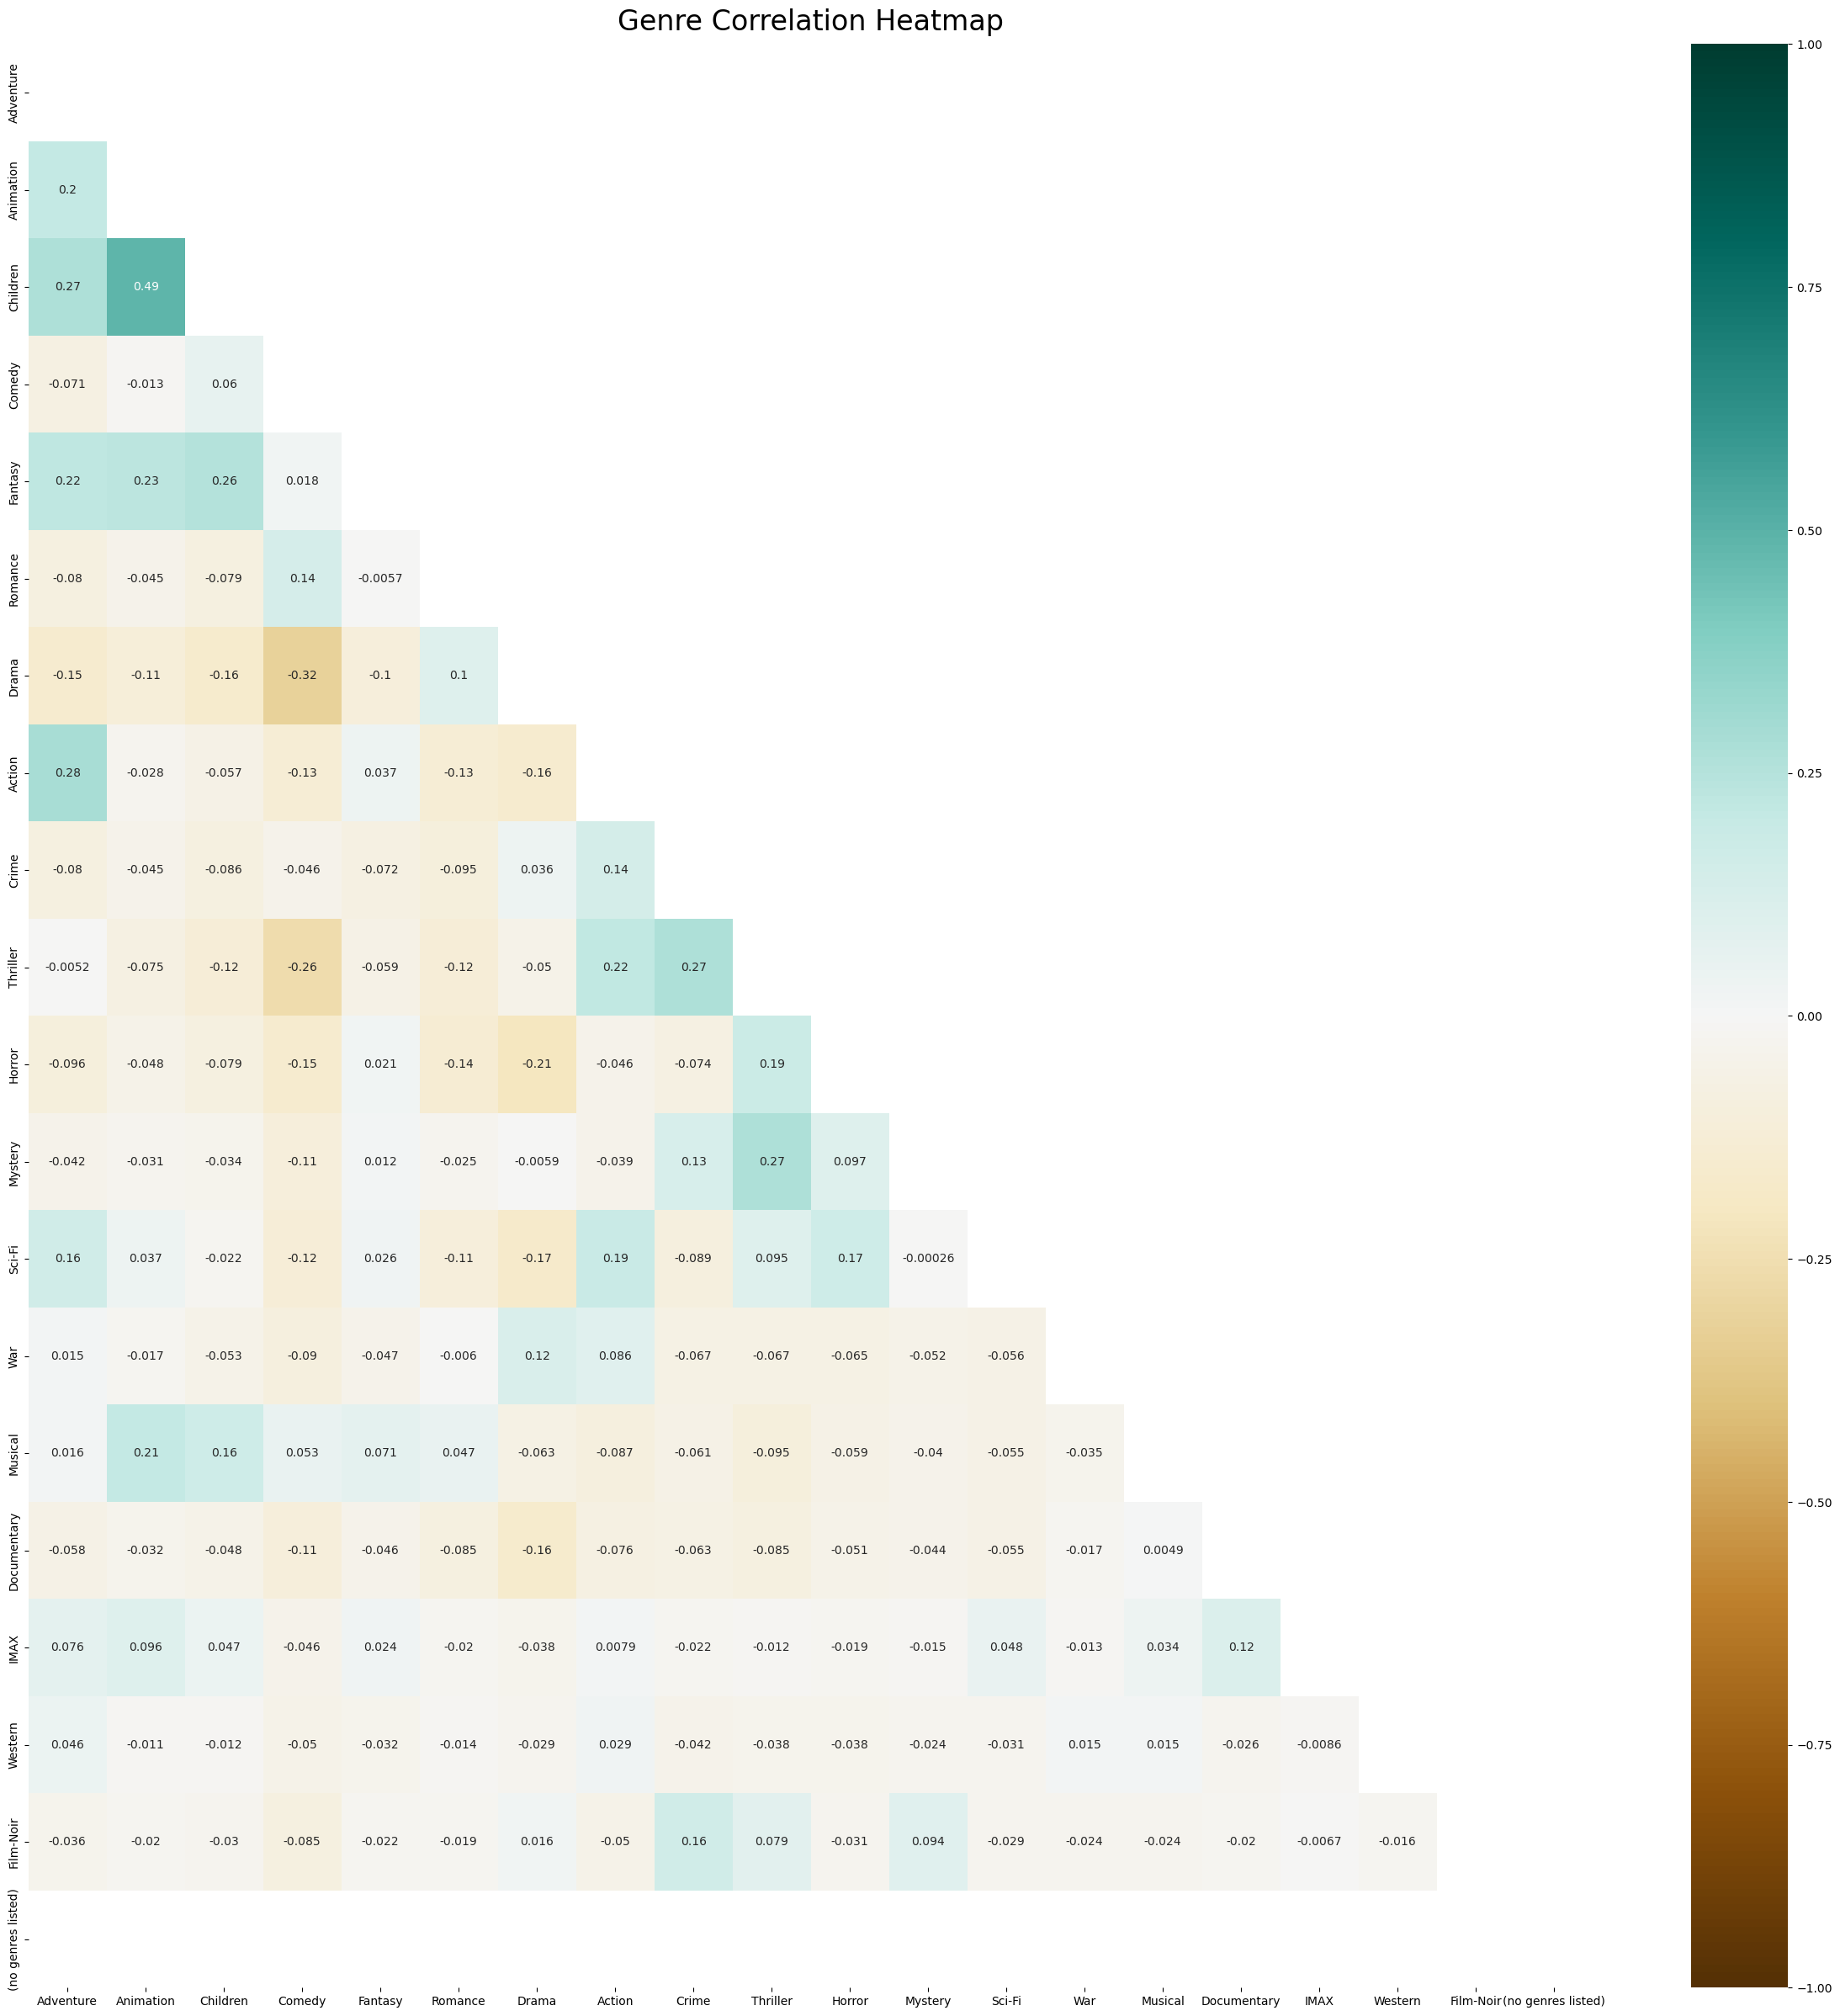

In [605]:
df_matrix = movie_genre_matrix.drop(columns='movieId')

corr_matrix = df_matrix.corr()

plt.figure(figsize=(30, 30))

#create a mask to remove the duplicate upper half
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

heatmap = sns.heatmap(corr_matrix, vmin=-1, mask=mask, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Genre Correlation Heatmap', fontdict={'fontsize':24}, pad=12);

In [606]:
#looks good!
movies

title  \
movieId                                       
1                                 Toy Story   
2                                   Jumanji   
3                          Grumpier Old Men   
4                         Waiting to Exhale   
5               Father of the Bride Part II   
...                                     ...   
193581   Black Butler: Book of the Atlantic   
193583                No Game No Life: Zero   
193585                                Flint   
193587         Bungo Stray Dogs: Dead Apple   
193609         Andrew Dice Clay: Dice Rules   

                                                    genres  year  avg_rating  \
movieId                                                                        
1        [Adventure, Animation, Children, Comedy, Fantasy]  1995    3.920930   
2                           [Adventure, Children, Fantasy]  1995    3.431818   
3                                        [Comedy, Romance]  1995    3.259615   
4                                 [Comedy, Drama, Romance]  1995    2.357143   
5                                                 [Comedy]  1995    3.071429   
...                                                    ...   ...         ...   
193581                [Action, Animation, Comedy, Fantasy]  2017    4.000000   
193583                        [Animation, Comedy, Fantasy]  2017    3.500000   
193585                                             [Drama]  2017    3.500000   
193587                                 [Action, Animation]  2018    3.500000   
193609                                            [Comedy]  1991    4.000000   

         num_reviews decade  
movieId                      
1              215.0  1990s  
2              110.0  1990s  
3               52.0  1990s  
4                7.0  1990s  
5               49.0  1990s  
...              ...    ...  
193581           1.0  2010s  
193583           1.0  2010s  
193585           1.0  2010s  
193587           1.0  2010s  
193609           1.0  1990s  

[9742 rows x 6 columns]

### Ratings

In [607]:
#problem: timestamp not human readable, nice to have real names as well
ratings.sample(5)

userId  movieId  rating   timestamp
47719     308      161     1.0  1421374403
24619     170      376     3.0   840473290
50341     325     2302     3.0  1039395597
30876     216     4002     3.0   975212110
42744     288     3210     3.0   976120587

In [608]:
#times now datetime
ratings['timestamp'] = ratings['timestamp'].map(datetime.fromtimestamp)

In [609]:
ratings['title'] = ratings['movieId'].map(get_movie_name)

In [610]:
ratings.describe()

userId        movieId         rating  \
count  100836.000000  100836.000000  100836.000000   
mean      326.127564   19435.295718       3.501557   
min         1.000000       1.000000       0.500000   
25%       177.000000    1199.000000       3.000000   
50%       325.000000    2991.000000       3.500000   
75%       477.000000    8122.000000       4.000000   
max       610.000000  193609.000000       5.000000   
std       182.618491   35530.987199       1.042529   

                           timestamp  
count                         100836  
mean   2008-03-19 12:38:29.931839488  
min              1996-03-29 13:36:55  
25%              2002-04-18 05:57:46  
50%              2007-08-02 16:31:02  
75%       2015-07-04 03:15:44.500000  
max              2018-09-24 10:27:30  
std                              NaN

## Visualizing the Data

In [611]:
temp_year = movies.sort_values(by=['year'])
fig = px.scatter(temp_year, x='year', y='avg_rating', hover_data=['title', 'num_reviews'])

fig.update_layout(
    title_text='Movies ratings by Year', # title of plot
    xaxis_title_text='Year', # xaxis label
    yaxis_title_text='Rating', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
)

fig.show()

In [612]:
df_temp = movies.groupby('decade').mean(numeric_only=True)

fig = px.bar(df_temp, y='avg_rating', text_auto=True)

fig.update_layout(
    title_text='Average Reviews of movies per decade', # title of plot
    xaxis_title_text='Decade', # xaxis label
    yaxis_title_text='Average Rating', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
)

fig.show()

In [613]:

fig = px.histogram(ratings, x='rating',
                            text_auto=True,
                            labels={'x':'rating', 'y':'count'},
                            color='rating',
                            color_discrete_sequence=["SandyBrown", "Gold", 'Coral', 'Salmon', "OrangeRed", 'SandyBrown', "Coral", 'Salmon', "red", 'OrangeRed'],
                            )

fig.update_layout(
    title_text='Number of Ratings', # title of plot
    xaxis_title_text='Rating', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
)

fig.show()

In [614]:
temp_df = ratings.groupby(['title', 'movieId']).count().sort_values(by='rating',ascending=False).reset_index().iloc[0:10,:]

temp_df['average rating'] = temp_df['movieId'].map(get_movie_rating)

fig = px.bar(temp_df, x = 'title', y = 'userId',text_auto=True, hover_data='average rating')

fig.update_layout(
    title_text='Most frequently rated movies', # title of plot
    xaxis_title_text='Movie', # xaxis label
    yaxis_title_text='Number of Ratings', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
)

fig.show()

In [615]:
#The average movie has 14 reviews
rated_movies = movies.loc[movies['num_reviews'] >= 14]

# Find Highest rated movies:
top_10 = rated_movies.sort_values(by=['avg_rating','num_reviews'],ascending=False)[:10]


fig = px.bar(top_10, x = 'title', y = 'avg_rating',text_auto=True)
fig.update_layout(
    title_text='Higest rated movies with more than 14 reviews', # title of plot
    xaxis_title_text='Movie', # xaxis label
    yaxis_title_text='Number of Ratings', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
)
fig.update_yaxes(range=[0, 5])
fig.show()

# Lowest rated movies
lowest_10 = rated_movies.sort_values(by=['avg_rating','num_reviews'],ascending=True)[:10]

fig = px.bar(lowest_10, x = 'title', y = 'avg_rating',text_auto=True)
fig.update_layout(
    title_text='Lowest rated movies with more than 14 reviews', # title of plot
    xaxis_title_text='Movie', # xaxis label
    yaxis_title_text='Number of Ratings', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
)
fig.update_yaxes(range=[0, 5])

fig.show()

# Cosine Similarity for Movie Genres (Item Based Recomendation, No Users)

The cosine similarity is a metric to determine how similar different things are.

In [616]:
from sklearn.metrics.pairwise import cosine_similarity

In [617]:
#get a random movie
test_movie = np.random.choice(movies.shape[0])
get_movie_name(test_movie)

"We Don't Live Here Anymore"

In [618]:
def top_k_items(item_id, top_k, corr_mat, map_name):

    # sort correlation value ascendingly and select top_k item_id
    top_items = corr_mat[item_id,:].argsort()[-top_k:]
    top_items = [map_name[e] for e in top_items]

    return top_items


# compute similarity matix
corr_mat = cosine_similarity(movie_genre_matrix)

# get top-k similar items
ind2name = {ind:name for ind,name in enumerate(movie_genre_matrix.index)}
name2ind = {v:k for k,v in ind2name.items()}
similar_items = top_k_items(name2ind[test_movie],
                            top_k = 3,
                            corr_mat = corr_mat,
                            map_name = ind2name)

# display result
print(f'The top-3 similar movie to: {get_movie_name(test_movie)}')
for movie in similar_items:
    print(f'Movie: {get_movie_name(movie)}')
    print(f'        Correlation: {corr_mat[movie]}')
    print(f'        Genres: {get_movie_genres(movie)}')

ValueError: Input contains NaN.

This provides us a general reccomendation for movies based on shared genres.

# K-Nearest Neighbors (Item Based Reccomendation, Collaborative)

Note: This is not a classifier or regression, so there is no train test split or validation. It is another distance comparison

In [619]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

In [620]:
#make a pivot table containing movies, ratings, and user Ids
data = pd.merge(movies,ratings)
#fill unrated movies with 0s because KNN does not like nas
user_movie_table = data.pivot_table(index = ["title"],columns = ["userId"],values = "rating").fillna(0)
user_movie_table.sample(10)

userId                                              1    2    3    4    5    \
title                                                                         
Dampfnudelblues                                     0.0  0.0  0.0  0.0  0.0   
Town, The                                           0.0  4.5  0.0  0.0  0.0   
Nerve                                               0.0  0.0  0.0  0.0  0.0   
Evangelion: 2.0 You Can (Not) Advance (Evangeri...  0.0  0.0  0.0  0.0  0.0   
Eraser                                              0.0  0.0  0.0  0.0  0.0   
Two for the Money                                   0.0  0.0  0.0  0.0  0.0   
11:14                                               0.0  0.0  0.0  0.0  0.0   
My Big Fat Greek Wedding 2                          0.0  0.0  0.0  0.0  0.0   
Buddy Boy                                           0.0  0.0  0.0  0.0  0.0   
À nous la liberté (Freedom for Us)                  0.0  0.0  0.0  0.0  0.0   

userId                                              6    7    8    9    10   \
title                                                                         
Dampfnudelblues                                     0.0  0.0  0.0  0.0  0.0   
Town, The                                           0.0  0.0  0.0  0.0  0.0   
Nerve                                               0.0  0.0  0.0  0.0  0.0   
Evangelion: 2.0 You Can (Not) Advance (Evangeri...  0.0  0.0  0.0  0.0  0.0   
Eraser                                              0.0  0.0  0.0  0.0  0.0   
Two for the Money                                   0.0  0.0  0.0  0.0  0.0   
11:14                                               0.0  0.0  0.0  0.0  0.0   
My Big Fat Greek Wedding 2                          0.0  0.0  0.0  0.0  0.0   
Buddy Boy                                           0.0  0.0  0.0  0.0  0.0   
À nous la liberté (Freedom for Us)                  0.0  0.0  0.0  0.0  0.0   

userId                                              ...  601  602  603  604  \
title                                               ...                       
Dampfnudelblues                                     ...  0.0  0.0  0.0  0.0   
Town, The                                           ...  0.0  0.0  0.0  0.0   
Nerve                                               ...  0.0  0.0  0.0  0.0   
Evangelion: 2.0 You Can (Not) Advance (Evangeri...  ...  0.0  0.0  0.0  0.0   
Eraser                                              ...  0.0  4.0  0.0  0.0   
Two for the Money                                   ...  0.0  0.0  0.0  0.0   
11:14                                               ...  0.0  0.0  0.0  0.0   
My Big Fat Greek Wedding 2                          ...  0.0  0.0  0.0  0.0   
Buddy Boy                                           ...  0.0  0.0  0.0  0.0   
À nous la liberté (Freedom for Us)                  ...  0.0  0.0  0.0  0.0   

userId                                              605  606  607  608  609  \
title                                                                         
Dampfnudelblues                                     0.0  0.0  0.0  0.0  0.0   
Town, The                                           0.0  0.0  0.0  0.0  0.0   
Nerve                                               0.0  0.0  0.0  0.0  0.0   
Evangelion: 2.0 You Can (Not) Advance (Evangeri...  0.0  0.0  0.0  0.0  0.0   
Eraser                                              0.0  0.0  0.0  3.0  3.0   
Two for the Money                                   0.0  0.0  0.0  0.0  0.0   
11:14                                               0.0  0.0  0.0  0.0  0.0   
My Big Fat Greek Wedding 2                          0.0  0.0  0.0  0.0  0.0   
Buddy Boy                                           0.0  0.0  0.0  0.0  0.0   
À nous la liberté (Freedom for Us)                  0.0  0.0  0.0  0.0  0.0   

userId                                              610  
title                                                    
Dampfnudelblues                                     0.0  
Town, The                     

In [621]:
#the test movie will be different because the indexes changed in the pivot table
print("Choosen Movie is: ",user_movie_table.index[test_movie])

Choosen Movie is:  Unfinished Life, An


In [622]:
#create a real sparse matrix
movie_table_matrix = csr_matrix(user_movie_table.values)
#use cosine distance like earlier
model_knn = NearestNeighbors(metric = 'cosine')
model_knn.fit(movie_table_matrix)
distances, indices = model_knn.kneighbors(user_movie_table.iloc[test_movie,:].values.reshape(1,-1), n_neighbors = 6)

In [623]:
movie = []
distance = []

for i in range(0, len(distances.flatten())):
    if i != 0:
        movie.append(user_movie_table.index[indices.flatten()[i]])
        distance.append(distances.flatten()[i])

m_series = pd.Series(movie,name='movie')
d_series = pd.Series(distance,name='distance')
recommended = pd.concat([m_series, d_series], axis=1)
recommended = recommended.sort_values('distance',ascending=False)

print('Recommendations for {0}:\n'.format(user_movie_table.index[test_movie]))
for i in range(0, recommended.shape[0]):
    print(f'{recommended["movie"].iloc[i]}, with distance of {recommended["distance"].iloc[i]}')

Recommendations for Unfinished Life, An:

Two for the Money, with distance of 0.0
My Name Is Bruce, with distance of 0.0
Bless the Child, with distance of 0.0
Helter Skelter, with distance of 0.0
Many Adventures of Winnie the Pooh, The, with distance of 0.0


# Using Surprize! (User-based, Collaborative)

In [16]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357285 sha256=45fa9b529d8326256b43afcdc6f29e53528aa863a1abbe4bbd4b56a30662590f
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [17]:
from surprise import SVD, accuracy
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise.model_selection.split import train_test_split
from collections import defaultdict

In [18]:
# preprocessing the data
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader)
train, test = train_test_split(data, test_size=.2, random_state=42)

# initial model
algo = SVD(random_state = 42)
algo.fit(train)
predictions = algo.test(test)

# evaluate the rmse result of the prediction and ground thuth
accuracy.rmse(predictions)

RMSE: 0.8807


0.8807462819979623

In [21]:
def get_top_picks(predictions, num_recs = 10):
    """Return the top-N recommendation for each user from a set of predictions.

    predictions(list of Prediction objects): The list of predictions, as returned by suprise's algorithm.
    num_recs (int): The number of recommendation to output for each user. Default is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size num_recs.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:num_recs]

    return top_n

top_n = get_top_picks(predictions, num_recs=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

140 [2947, 953, 1036, 5995, 6787, 2067, 1408, 48516, 1234, 3578]
603 [1221, 290, 2858, 1172, 1193, 85, 2692, 36, 1248, 912]
438 [4011, 4223, 34405, 4993, 7451, 4995, 5902, 1732, 8949, 1196]
433 [608, 1089, 296, 164179]
474 [1283, 1172, 5618, 720, 260, 914, 17, 48516, 3083, 3451]
304 [318, 1035, 1704, 2502, 593, 457, 356, 60, 733, 474]
298 [260, 5618, 1210, 2858, 1625, 54503, 1285, 48516, 3578, 1222]
131 [1213, 1193, 1228, 293, 593, 1200, 1617, 4226, 1136, 1288]
288 [1258, 8874, 908, 7153, 1250, 2571, 2959, 1261, 2028, 3507]
448 [296, 32, 112552, 1198, 48516, 1200, 109374, 778, 1214, 1704]
284 [296, 318, 356, 590, 342, 357, 104, 380, 112, 433]
331 [79132, 58559, 134130, 55765, 33794, 54997, 8636, 48394, 34, 6936]
325 [969, 356, 2186, 1682, 1090, 1304, 919, 3267, 1280, 1610]
504 [4027, 296, 5060, 4995, 3897, 4306, 3556, 5445, 5673, 2797]
286 [2329, 4973, 2028, 4848, 4571, 364, 6377, 2692, 150, 5989]
232 [527, 5418, 78499, 1198, 745, 58559, 68157, 44191, 7143, 44199]
6 [50, 475, 589, 553,

Our RMSE being 1.8 means that we are off, on average, by 1.8 points.

# Getting recomendations for a normal user

As we already have user recomendations, we will be using suprise for recomendations, and checking our work based on how similar the moves are with our distance metrics.

In [52]:
target_user = ratings.sample(random_state=42)['userId'].iloc[0]
target_user

432

In [47]:
#take a look at the user's preferences
target_user_df = ratings.loc[ratings['userId']==target_user]
target_user_df = target_user_df.sort_values(by=['rating'],ascending=False)
target_user_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 260 entries, 66909 to 66950
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     260 non-null    int64  
 1   movieId    260 non-null    int64  
 2   rating     260 non-null    float64
 3   timestamp  260 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 10.2 KB


In [48]:
#only use movies we can name
target_user_df['title'] = target_user_df['movieId'].map(get_movie_name)
target_user_df['genres'] = target_user_df['movieId'].map(get_movie_genres)

target_user_df = target_user_df[target_user_df.title != 'Movie not found']

In [49]:
#from the larger dataset I know their least favorite is The Ape 0.5
target_user_df

userId  movieId  rating   timestamp  \
66909     432     3949     5.0  1315242940   
67045     432    81591     5.0  1315244863   
67029     432    71379     5.0  1316391330   
66971     432     8533     5.0  1315244178   
66864     432     1835     5.0  1315244490   
...       ...      ...     ...         ...   
66957     432     6947     1.5  1335139655   
66876     432     2278     1.0  1315242196   
66886     432     2683     0.5  1316391662   
66849     432     1293     0.5  1315242191   
66950     432     6539     0.5  1316391748   

                                                   title  \
66909                                Requiem for a Dream   
67045                                         Black Swan   
67029                                Paranormal Activity   
66971                                      Notebook, The   
66864                                     City of Angels   
...                                                  ...   
66957    Master and Commander: The Far Side of the World   
66876                                              Ronin   
66886              Austin Powers: The Spy Who Shagged Me   
66849                                             Gandhi   
66950  Pirates of the Caribbean: The Curse of the Bla...   

                                     genres  
66909                               [Drama]  
67045                     [Drama, Thriller]  
67029                    [Horror, Thriller]  
66971                      [Drama, Romance]  
66864             [Drama, Fantasy, Romance]  
...                                     ...  
66957               [Adventure, Drama, War]  
66876             [Action, Crime, Thriller]  
66886           [Action, Adventure, Comedy]  
66849                               [Drama]  
66950  [Action, Adventure, Comedy, Fantasy]  

[260 rows x 6 columns]

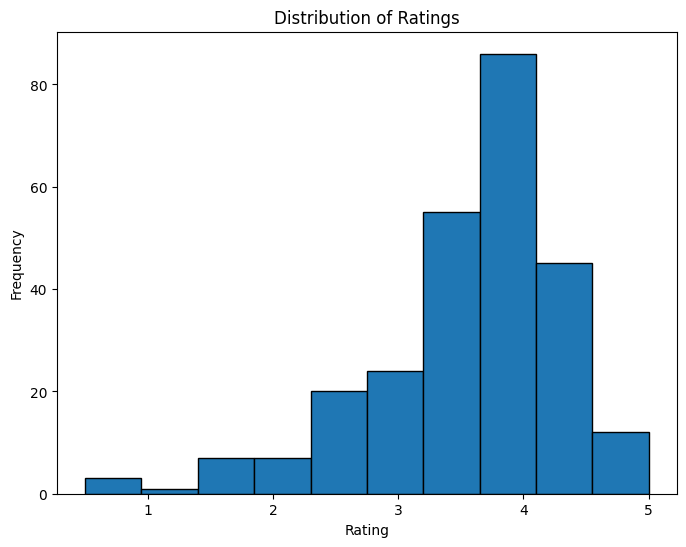

In [54]:
# @title Distribution of Ratings

plt.figure(figsize=(8, 6))
plt.hist(target_user_df['rating'], bins=10, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
_ = plt.title('Distribution of Ratings')

In [58]:
top_10_user = target_user_df[:10]
top_10_user

userId  movieId  rating   timestamp                title  \
66909     432     3949     5.0  1315242940  Requiem for a Dream   
67045     432    81591     5.0  1315244863           Black Swan   
67029     432    71379     5.0  1316391330  Paranormal Activity   
66971     432     8533     5.0  1315244178        Notebook, The   
66864     432     1835     5.0  1315244490       City of Angels   
66865     432     1873     5.0  1316391161      Misérables, Les   
66871     432     1997     5.0  1316391091        Exorcist, The   
66818     432      364     5.0  1316391519       Lion King, The   
66992     432    45503     5.0  1316391388     Peaceful Warrior   
67007     432    57274     5.0  1316391360                [REC]   

                                                  genres  
66909                                            [Drama]  
67045                                  [Drama, Thriller]  
67029                                 [Horror, Thriller]  
66971                                   [Drama, Romance]  
66864                          [Drama, Fantasy, Romance]  
66865                       [Crime, Drama, Romance, War]  
66871                                  [Horror, Mystery]  
66818  [Adventure, Animation, Children, Drama, Musica...  
66992                                            [Drama]  
67007                          [Drama, Horror, Thriller]

In [61]:
bottom_10_user = target_user_df[-10:]
bottom_10_user

userId  movieId  rating   timestamp  \
66834     432      780     1.5  1316391462   
66901     432     3273     1.5  1315242328   
66816     432      344     1.5  1316391506   
66982     432    33158     1.5  1315242713   
66934     432     5507     1.5  1315242710   
66957     432     6947     1.5  1335139655   
66876     432     2278     1.0  1315242196   
66886     432     2683     0.5  1316391662   
66849     432     1293     0.5  1315242191   
66950     432     6539     0.5  1316391748   

                                                   title  \
66834                      Independence Day (a.k.a. ID4)   
66901                                           Scream 3   
66816                         Ace Ventura: Pet Detective   
66982                            xXx: State of the Union   
66934                                                xXx   
66957    Master and Commander: The Far Side of the World   
66876                                              Ronin   
66886              Austin Powers: The Spy Who Shagged Me   
66849                                             Gandhi   
66950  Pirates of the Caribbean: The Curse of the Bla...   

                                      genres  
66834  [Action, Adventure, Sci-Fi, Thriller]  
66901    [Comedy, Horror, Mystery, Thriller]  
66816                               [Comedy]  
66982              [Action, Crime, Thriller]  
66934              [Action, Crime, Thriller]  
66957                [Adventure, Drama, War]  
66876              [Action, Crime, Thriller]  
66886            [Action, Adventure, Comedy]  
66849                                [Drama]  
66950   [Action, Adventure, Comedy, Fantasy]

In [50]:
top_n[target_user]

[(912, 4.226976513678512),
 (5952, 4.2228780816318086),
 (4886, 4.178277744210748),
 (4973, 4.177529351747113),
 (4306, 4.152281623746379),
 (7153, 4.068506270452766),
 (3949, 4.044446968440032),
 (3147, 4.019193875263596),
 (6947, 4.010385103326618),
 (69481, 3.9677129843717935)]

In [51]:
for n in top_n[target_user]:
    print(get_movie_name(n[0]))

Casablanca
Lord of the Rings: The Two Towers, The
Monsters, Inc.
Amelie (Fabuleux destin d'Amélie Poulain, Le)
Shrek
Lord of the Rings: The Return of the King, The
Requiem for a Dream
Green Mile, The
Master and Commander: The Far Side of the World
Hurt Locker, The
